In [9]:
NUMBER_OF_EPOCH = 50000

In [10]:
import torch
import torch.nn as nn
import pandas as pd
import preprossesing as pre
import math
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='mps:0')


In [11]:
def prepare_model(df):
    
    # df = pre.standardize(df)
    df = pre.encoder(df)
    df = df.drop(['id'], axis=1)

    train, val = pre.test_validation_split(df)
    
    y_train = torch.tensor(train['price'].values, dtype=torch.float32)
    X_train = train.drop(['price'], axis=1)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    
    y_val = torch.tensor(val['price'].values, dtype=torch.float32)
    X_val = val.drop(['price'], axis=1)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    
    return X_train, y_train, X_val, y_val

In [12]:
# Define model
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Linear(171, 256),
        nn.ReLU(), 
        
        nn.Linear(256, 128),
        nn.ReLU(),
        
        nn.Linear(128, 1) 
        )
    
        
    def forward(self, x):
        
        return self.layers(x)

model = mlp()
model

mlp(
  (layers): Sequential(
    (0): Linear(in_features=171, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [13]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [14]:
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [15]:
df = pd.read_csv('data/train.csv')
X_train, y_train, X_val, y_val = prepare_model(df)

In [16]:
import numpy as np
best_val_loss = float('inf')
training_loss = np.array([])
validation_loss = np.array([])
last_val_loss = float('inf')
count = 0

for n in range(NUMBER_OF_EPOCH):
    model.train()
    y_pred = model(X_train)[:, 0]
    loss = loss_fn(y_pred, y_train)
    training_loss = np.append(training_loss, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    y_pred = model(X_val)[:, 0]
    val_loss = loss_fn(y_pred, y_val)
    validation_loss = np.append(validation_loss, val_loss.item())
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'mlp_model.pth')
    
    if n % 100 == 0:
        print(f'Epoch: {n} Loss: {loss.item()}'f' Validation loss: {val_loss.item()}'f' best Validation loss: {best_val_loss}')
        
    if last_val_loss < val_loss:
        count += 1
        if count == 25:
            break
    else:
        count = 0
    last_val_loss = val_loss
    

Epoch: 0 Loss: 18018.087890625 Validation loss: 18092.79296875 best Validation loss: 18092.79296875
Epoch: 100 Loss: 6941.8642578125 Validation loss: 7089.32568359375 best Validation loss: 7089.32568359375
Epoch: 200 Loss: 6845.24951171875 Validation loss: 6994.78076171875 best Validation loss: 6994.78076171875
Epoch: 300 Loss: 6800.666015625 Validation loss: 6949.02392578125 best Validation loss: 6949.02392578125
Epoch: 400 Loss: 6744.74853515625 Validation loss: 6892.39306640625 best Validation loss: 6892.39306640625
Epoch: 500 Loss: 6664.37744140625 Validation loss: 6811.27392578125 best Validation loss: 6811.27392578125
Epoch: 600 Loss: 6536.5546875 Validation loss: 6688.25048828125 best Validation loss: 6688.25048828125
Epoch: 700 Loss: 6350.93701171875 Validation loss: 6505.86181640625 best Validation loss: 6497.380859375
Epoch: 800 Loss: 6041.82177734375 Validation loss: 6204.19677734375 best Validation loss: 6204.12890625
Epoch: 900 Loss: 5753.22705078125 Validation loss: 5924.

KeyboardInterrupt: 

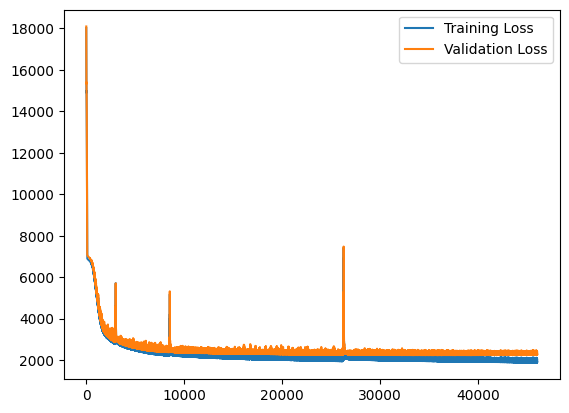

In [17]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')

In [18]:
import pickle

df = pd.read_csv('data/test.csv')
model = torch.load('mlp_model.pth')
model.eval()

index = df['id']
df = df.drop(['id'], axis=1)
X = pre.encoder(df)
# X = pre.standardize(X, scaler=pickle.load(open('scaler.pkl', 'rb')))
X = torch.tensor(X.values, dtype=torch.float32)
y_pred = model(X)[:, 0]

df = pd.DataFrame(y_pred.detach().numpy(), columns=['price'])
df = pd.concat([index, df], axis=1)
df.rename(columns={'price': 'answer'}, inplace=True)
df.to_csv('output.csv', index=False)

/var/folders/64/cy9kvd894_bfkfb71dsbxt2w0000gn/T/ipykernel_16962/3527652370.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mlp_model.pth')
